In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import pandas as pd

# from tigramite.data_processing import DataFrame
# from tigramite.pcmci import PCMCI
# from tigramite.independence_tests.parcorr import ParCorr

import pcmcirustpy

In [3]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np

# -------------------------------
# ✅ 1) Define robust variables
# -------------------------------
series = {
    # Monetary & financial
    "Interest_Rate": "FEDFUNDS",
    "Long_Term_Rate": "GS10",
    "Credit_Spread": "BAA10Y",

    # Prices & expectations
    "CPI": "CPIAUCSL",  # Use to compute YoY inflation
    "Inflation_Expectations": "MICH",
    "House_Prices": "USSTHPI",

    # Output & supply side
    "GDP": "GDPC1",
    "Industrial_Production": "INDPRO",
    "Productivity": "OPHNFB",
    "Capacity_Utilization": "TCU",
    "Employment": "PAYEMS",

    # External sector
    "Exports": "EXPGS",
    "Imports": "IMPGS",
    "Real_Exchange_Rate": "RBUSBIS",

    # Fiscal policy
    "Public_Debt_GDP_Ratio": "GFDEGDQ188S",
    "Govt_Expenditures": "FGEXPND",
    "Govt_Gross_Investment": "A782RC1Q027SBEA",
    "Private_Investment": "GPDIC1",

    # Prices & commodity cycle
    "Oil_Price": "POILWTIUSDM",
    "Commodity_Index": "PALLFNFINDEXQ",

    # Sentiment
    "Consumer_Confidence": "UMCSENT",
}

# -------------------------------
# ✅ 2) Download data
# -------------------------------
start = "1980-01-01"  # Extend back for more observations
end = "2024-12-31"

df = pd.DataFrame()
for name, code in series.items():
    if code:
        try:
            df[name] = web.DataReader(code, "fred", start, end)[code]
        except Exception as e:
            print(f"Error loading {name}: {e}")

# -------------------------------
# ✅ 3) Resample to quarterly & transforms
# -------------------------------
df_q = df.resample("Q").mean()

# -------------------------------
# 4) Robust transforms
# -------------------------------
df_q["GDP_Growth"] = df_q["GDP"].pct_change(4) * 100
df_q["Productivity_Growth"] = np.log(df_q["Productivity"]).diff() * 100
df_q["Employment_Growth"] = df_q["Employment"].pct_change() * 100
df_q["Capacity_Utilization"] = df_q["Capacity_Utilization"]

df_q["Inflation_Rate"] = df_q["CPI"].pct_change(4) * 100

df_q["Oil_Price_Growth"] = np.log(df_q["Oil_Price"]).diff() * 100
df_q["Commodity_Index_Growth"] = np.log(df_q["Commodity_Index"]).diff() * 100

df_q["Exports_Growth"] = df_q["Exports"].pct_change(1) * 100
df_q["Imports_Growth"] = df_q["Imports"].pct_change(1) * 100
df_q["Real_Exchange_Rate_Growth"] = np.log(df_q["Real_Exchange_Rate"]).diff() * 100

df_q["Govt_Expenditures_Growth"] = df_q["Govt_Expenditures"].pct_change() * 100
df_q["Govt_Gross_Investment_Growth"] = df_q["Govt_Gross_Investment"].pct_change() * 100
df_q["Private_Investment_Growth"] = df_q["Private_Investment"].pct_change() * 100
df_q["Public_Debt_GDP_Change"] = df_q["Public_Debt_GDP_Ratio"].diff()

df_q["Yield_Curve_Slope"] = df_q["Long_Term_Rate"] - df_q["Interest_Rate"]
df_q["Interest_Rate"] = df_q["Interest_Rate"]
df_q["Credit_Spread"] = df_q["Credit_Spread"]

df_q["Consumer_Confidence"] = df_q["Consumer_Confidence"]
df_q["House_Prices_Growth"] = np.log(df_q["House_Prices"]).diff() * 100

# -------------------------------
# ✅ 5) Drop redundant raw levels
# -------------------------------
# Remove levels that were replaced
df_q = df_q.drop(columns=[
    "CPI", "GDP", "Productivity", "Employment",
    "Oil_Price", "Commodity_Index",
    "Exports", "Imports",
    "Govt_Expenditures", "Govt_Gross_Investment",
    "Private_Investment", "Public_Debt_GDP_Ratio",
    "Real_Exchange_Rate",
    "Long_Term_Rate", "House_Prices"
], errors='ignore')

# Final index check
df_q = df_q.sort_index()

# -------------------------------
# ✅ 6) Final cleanup
# -------------------------------
# Drop any rows with remaining NA values
df_q = df_q.dropna()

# Standardize (optional but helps)
df_q = (df_q - df_q.mean()) / df_q.std()

print("✅ Final robust variables for PCMCI:", df_q.columns.tolist())
print(df_q.head())
print("✅ Shape:", df_q.shape)

✅ Final robust variables for PCMCI: ['Interest_Rate', 'Credit_Spread', 'Inflation_Expectations', 'Industrial_Production', 'Capacity_Utilization', 'Consumer_Confidence', 'GDP_Growth', 'Productivity_Growth', 'Employment_Growth', 'Inflation_Rate', 'Oil_Price_Growth', 'Commodity_Index_Growth', 'Exports_Growth', 'Imports_Growth', 'Real_Exchange_Rate_Growth', 'Govt_Expenditures_Growth', 'Govt_Gross_Investment_Growth', 'Private_Investment_Growth', 'Public_Debt_GDP_Change', 'Yield_Curve_Slope', 'House_Prices_Growth']
            Interest_Rate  Credit_Spread  Inflation_Expectations  \
DATE                                                               
2003-06-30      -0.244528       0.692200               -1.463438   
2003-09-30      -0.365934       0.395032               -1.226109   
2003-12-31      -0.376491       0.018135               -0.798915   
2004-03-31      -0.372972      -0.315274               -0.656517   
2004-06-30      -0.369453      -0.373258                0.102938   

        

/var/folders/6t/q5qz8h391z5glwmcphxhx9bm0000gn/T/ipykernel_46809/3040069205.py:62: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_q = df.resample("Q").mean()


In [11]:
from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

# Set-up the PCMCI object using ParCorr as the conditional independence test.
pcmci_obj = PCMCI(dataframe=DataFrame(df_q.values, var_names=df_q.columns), cond_ind_test=ParCorr())

# Run PCMCI with the maximum lag provided
start = time.time()
results_tigramite = pcmci_obj.run_pcmci(
    tau_max=4, 
    pc_alpha=0.05, 
    max_conds_dim=3,
    max_combinations=1
)
end = time.time()
print("Time taken:", end - start)

Time taken: 3.446780204772949


In [12]:
results_tigramite["p_matrix"]

array([[[1.00000000e+00, 3.32659891e-17, 8.09485070e-02, 8.97290918e-01,
         5.87434143e-01],
        [3.42670177e-06, 2.66257840e-01, 1.56629891e-01, 1.33145096e-03,
         4.19754516e-01],
        [4.60875873e-01, 4.35339360e-05, 6.06351469e-01, 1.31982695e-01,
         8.39402874e-01],
        ...,
        [1.25343735e-05, 2.74459622e-01, 3.22438241e-01, 7.13103179e-01,
         6.69385825e-01],
        [1.43531629e-04, 3.28443329e-03, 2.50377651e-02, 1.86258440e-01,
         6.96026897e-02],
        [3.54723698e-02, 9.40774110e-01, 7.09047284e-01, 9.49695966e-01,
         3.04938892e-01]],

       [[3.42670177e-06, 3.09129884e-02, 6.86815791e-01, 5.19544332e-01,
         6.40301810e-01],
        [1.00000000e+00, 1.15542715e-09, 3.99321844e-01, 4.81879405e-01,
         2.96203510e-01],
        [1.09408208e-01, 3.50389451e-03, 1.00521010e-01, 3.87171202e-01,
         4.16243117e-01],
        ...,
        [1.80332475e-05, 6.97334981e-01, 9.35760302e-01, 4.48684797e-01,
        

In [14]:
result = pcmcirustpy.run_pcmci(
    df_q.values,
    max_lag=4,
    alpha=0.05,
    max_condition_set_size=3,
    max_subsets=1
)

print("P-matrix:")
print(result["p_matrix"])

print("\nEffect size matrix:")
print(result["val_matrix"])

P-matrix:
[[[           nan            nan 2.01746251e-02            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  ...
  [           nan            nan            nan            nan
              nan]
  [           nan 1.59867695e-03            nan            nan
   1.23393132e-05]
  [           nan            nan            nan            nan
              nan]]

 [[           nan            nan            nan            nan
              nan]
  [           nan 3.45021789e-11            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  ...
  [           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
              nan]
  [           nan            nan            nan            nan
           

In [17]:
import numpy as np

series = dict(zip(df_q.columns, df_q.columns))

for val in np.argwhere(~np.isnan(result["val_matrix"])):
    if result['p_matrix'][val[0], val[1], val[2]] < 0.05:
        print(
            f"{list(series.keys())[val[0]]} -> {list(series.keys())[val[1]]} at lag {val[2]}: "
            f"Effect size = {result['val_matrix'][val[0], val[1], val[2]]}, "
            f"P-value = {result['p_matrix'][val[0], val[1], val[2]]}"
        )

Interest_Rate -> Interest_Rate at lag 2: Effect size = -0.26782445123227916, P-value = 0.020174625108983824
Interest_Rate -> Yield_Curve_Slope at lag 1: Effect size = -0.3606054216267667, P-value = 0.0015986769497811082
Interest_Rate -> Yield_Curve_Slope at lag 4: Effect size = 0.47845044924255015, P-value = 1.2339313209430713e-05
Credit_Spread -> Credit_Spread at lag 1: Effect size = 0.6705210975856112, P-value = 3.4502178891671065e-11
Credit_Spread -> Industrial_Production at lag 1: Effect size = -0.24021576880602377, P-value = 0.03660379806567082
Credit_Spread -> Capacity_Utilization at lag 1: Effect size = -0.2938851574017441, P-value = 0.009973646400571745
Credit_Spread -> GDP_Growth at lag 1: Effect size = -0.38541296480781045, P-value = 0.0010742496589823958
Credit_Spread -> Govt_Gross_Investment_Growth at lag 3: Effect size = -0.4362819346037987, P-value = 6.5260752962093e-05
Inflation_Expectations -> Inflation_Expectations at lag 1: Effect size = 0.40261740282965536, P-value =

/Users/franmm/Library/Mobile Documents/com~apple~CloudDocs/Mis Datos/Master UNAV/TFM/code/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/franmm/Library/Mobile Documents/com~apple~CloudDocs/Mis Datos/Master UNAV/TFM/code/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/franmm/Library/Mobile Documents/com~apple~CloudDocs/Mis Datos/Master UNAV/TFM/code/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, f

✅ ARIMA RMSE: 1.5445
✅ PCMCI-ARIMAX RMSE: 0.8901
✅ ALL-ARIMAX RMSE: 3.0108


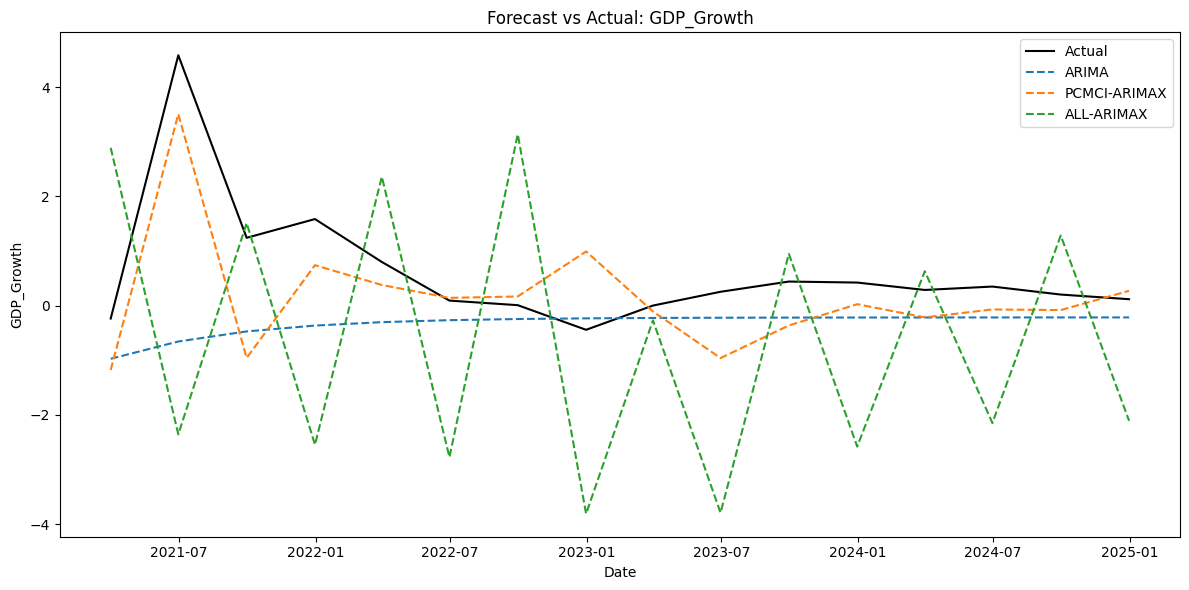

In [302]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------------
# 1) Pick your target and drivers
# ------------------------------------
target = "GDP_Growth"

# Use your PCMCI output
pcmci_drivers = [
    "Private_Investment_Growth",
    "Public_Debt_GDP_Change",
    "House_Prices_Growth"
]

# Create lagged features for PCMCI drivers
def add_lags(df, var, lags):
    for lag in lags:
        df[f"{var}_lag{lag}"] = df[var].shift(lag)
    return df

df = df_q.copy()

# Add the correct lags per PCMCI
df = add_lags(df, "Private_Investment_Growth", [3])
df = add_lags(df, "Public_Debt_GDP_Change", [4])
df = add_lags(df, "House_Prices_Growth", [2])

# Final PCMCI lags list
pcmci_lagged = [
    "Private_Investment_Growth_lag3",
    "Public_Debt_GDP_Change_lag4",
    "House_Prices_Growth_lag2"
]

# For ALL-ARIMAX, add 1 lag for simplicity
all_drivers = [col for col in df.columns if col != target]
for var in all_drivers:
    df[f"{var}_lag1"] = df[var].shift(1)
all_lagged = [col for col in df.columns if "_lag" in col]

df.dropna(inplace=True)

# ------------------------------------
# 2) Train/test split
# ------------------------------------
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# ------------------------------------
# 3) Fit ARIMA baseline
# ------------------------------------
model_arima = ARIMA(train[target], order=(1, 0, 0))
fit_arima = model_arima.fit()
pred_arima = fit_arima.forecast(steps=len(test))

# ------------------------------------
# 4) Fit PCMCI-ARIMAX
# ------------------------------------
model_pcmci = ARIMA(
    train[target],
    exog=train[pcmci_lagged],
    order=(1, 0, 0)
)
fit_pcmci = model_pcmci.fit()
pred_pcmci = fit_pcmci.forecast(steps=len(test), exog=test[pcmci_lagged])

# ------------------------------------
# 5) Fit ALL-ARIMAX
# ------------------------------------
model_all = ARIMA(
    train[target],
    exog=train[all_lagged],
    order=(1, 0, 0)
)
fit_all = model_all.fit()
pred_all = fit_all.forecast(steps=len(test), exog=test[all_lagged])

# ------------------------------------
# 6) Compare & plot
# ------------------------------------
rmse_arima = np.sqrt(mean_squared_error(test[target], pred_arima))
rmse_pcmci = np.sqrt(mean_squared_error(test[target], pred_pcmci))
rmse_all = np.sqrt(mean_squared_error(test[target], pred_all))

print(f"✅ ARIMA RMSE: {rmse_arima:.4f}")
print(f"✅ PCMCI-ARIMAX RMSE: {rmse_pcmci:.4f}")
print(f"✅ ALL-ARIMAX RMSE: {rmse_all:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Actual
plt.plot(test.index, test[target], label="Actual", color="black")

# Baseline ARIMA
plt.plot(test.index, pred_arima, label="ARIMA", linestyle="--")

# PCMCI-ARIMAX
plt.plot(test.index, pred_pcmci, label="PCMCI-ARIMAX", linestyle="--")

# ALL-ARIMAX
plt.plot(test.index, pred_all, label="ALL-ARIMAX", linestyle="--")

plt.title(f"Forecast vs Actual: {target}")
plt.xlabel("Date")
plt.ylabel(f"{target}")
plt.legend()
plt.tight_layout()
plt.show()

If your goal is forecasting, not causal inference, PCMCI can be:

✅ Useful to reduce dimensionality if you have tons of variables (PCMCI works espacially well with high-dimensional data).

🟡 Not necessary if you have a strong economic theory for which variables matter.

Yes, PCMCI output can help you select exogenous predictors.

But maybe simpler methods: theoretical selection, correlation, or even LASSO regression are enough.

PCMCI detects Granger-causal links, which means:
“Knowing X (with the right lag) helps predict Y beyond what Y’s own past does.”